In [11]:
import pandas as pd
import pickle as pkl
import numpy as np

import matplotlib.pyplot as plt

import scanpy as sc
%matplotlib inline
import matplotlib

import scanpy as sc
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

### Random baseline

In [12]:
def generate_random_rounds(all_genes, round0=None, rounds = 16, sample_size=64):
    past_set =list(all_genes)
    random_rounds = {}
    if round0 is not None:
        random_rounds[0] = round0
    else:
        random_rounds[0] = np.random.choice(all_genes, sample_size)
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_size)])
        past_set = list(selection_set)
        
    return random_rounds

def generate_random_rounds_custom(all_genes, rounds = 16, sample_sizes=None):
    past_set =list(all_genes)
    random_rounds = {}
    random_rounds[0] = []
    
    for i in range(1,rounds):
        selection_set = set(past_set).difference(set(random_rounds[i-1]))
        random_rounds[i] = np.concatenate([random_rounds[i-1], np.random.choice(list(selection_set), sample_sizes[i])])
        past_set = list(selection_set)
        
    return random_rounds

def return_hits(list_):
    return list(set(list_).intersection(set(topmovers)))

def get_all_sampled_genes(exp_path):
    all_sampled_genes = []
    num_rounds = len(glob.glob(exp_path + '*'))
    for i in range(1, num_rounds+1):
        exp_path_ = exp_path + str(i) + '.npy'
        all_sampled_genes.append(np.load(exp_path_))
    return all_sampled_genes

def get_successful_sample_sizes(sampled_genes):
    sizes = []
    prev_size = 0
    for sample in sampled_genes:
        sizes.append(len(sample)-prev_size)
        prev_size = prev_size + sizes[-1]
    return sizes

def return_hits(arr):
    return list(set(arr).intersection(set(topmovers)))

In [58]:
REPS = ['1', '2']
ACQUISITION_FUNCTIONS = ["random", "softuncertain", "topuncertain",
                         "marginsample", "coreset", "badge",
                         "kmeans_embedding", "kmeans_data"]
        #"adversarialBIM", "custom"
#ACQUISITION_FUNCTIONS = ["topuncertain"]
SCREEN_NAMES = ['IL2']

num_reps = len(REPS)
sample_size=32
num_steps = 15

screen_name = SCREEN_NAMES[0]
data_name = screen_name.lower()

data_df = pd.read_csv('/dfs/user/yhr/research_assistant_orig/datasets/ground_truth_'+screen_name+'.csv')
topmovers = np.load('/dfs/user/yhr/research_assistant_orig/datasets/topmovers_'+screen_name+'.npy')
all_genes = data_df['Gene'].values
data_df = data_df.set_index('Gene')

### ML Models

In [14]:
def get_random_hits(sample_size, num_steps = num_steps, num_reps=3):
    random_rounds = {}
    random_hits = {}
    random_hit_rates = {}

    for rep in range(1, num_reps+1):
        rep=str(rep)
        random_rounds[rep] = generate_random_rounds(all_genes, rounds = num_steps, sample_size=sample_size)
        #random_rounds[rep] = generate_random_rounds_custom(all_genes, rounds = num_steps, 
        #                                                   sample_sizes=sample_sizes[rep])

        random_hits[rep] = []
        random_hit_rates[rep] = []
        for step in range(num_steps):
            random_hits[rep].append(return_hits(random_rounds[rep][step]))
            random_hit_rates[rep].append(len(random_hits[rep][-1])/len(topmovers))
            
    return random_hit_rates, random_hits

In [15]:
# calculate the mean and standard deviation of the random data
random_hit_rates, random_hits = get_random_hits(sample_size, num_steps = num_steps, num_reps=num_reps)
random_mean = np.mean(np.array([x for x in random_hit_rates.values()]),0)
random_std = np.std(np.array([x for x in random_hit_rates.values()]),0)


### Claude

In [16]:
import os
import glob

#agent_paths = glob.glob('/dfs/user/yhr/AI_RA/research_assistant/logs/agent_log/IFNG/IFNG_exp??')
agent_paths = glob.glob('/dfs/scratch0/jianv/bio-logs/logs_Carnevale22_TGFb/dummy_summary*')
exp_paths = {i: os.path.join(path,'sampled_genes_') for i, path in enumerate(agent_paths)}

In [17]:
sampled_genes = {}
sample_sizes = {}
hits = {}
hit_rates = {}
num_rounds = num_steps
num_steps = num_steps
num_reps = len(exp_paths)
filter_zero_sets = True
min_rounds = num_steps

for rep in exp_paths:
    sampled_genes[rep] = get_all_sampled_genes(exp_paths[rep])
    sample_sizes[rep] = get_successful_sample_sizes(sampled_genes[rep])
    if np.sum(np.array(sample_sizes[rep]) > 0) < min_rounds:
        sampled_genes.pop(rep, None)
        continue
    
    if filter_zero_sets:
         sampled_genes[rep] = [sampled_genes[rep][itr] for itr in np.where(np.array(sample_sizes[rep])!= 0)[0]]

    hits[rep] = []
    hit_rates[rep] = []
    hits[rep] = [return_hits(x) for x in sampled_genes[rep]]
    hit_rates[rep] = [len(x)/len(topmovers) for x in hits[rep]]
    
num_steps_claude = np.min([len(x) for x in hit_rates.values()])

In [18]:
ai_ra_mean_claude = np.mean([x[:num_steps_claude] for x in hit_rates.values()],0)
ai_ra_std_claude = np.std(np.array([x[:num_steps_claude] for x in hit_rates.values()]),0)

In [19]:
sampled_genes = []
exp_name = f'/dfs/scratch0/jianv/bio-logs/logs_40_hugebatch_IFNG/dummy_summary{{}}/sampled_genes_15.npy'
num_genes = 480

for exp_id in range(10):
    try:
        exp_name_id = exp_name.format(exp_id)
        sampled_genes.append(np.load(exp_name_id))
    except:
        pass


In [20]:
sampled_genes_1shot = []
exp_name = f'/dfs/scratch0/jianv/bio-logs/logs_40_noobs_hugebatch_IFNG/dummy_summary{{}}/sampled_genes_1.npy'

for exp_id in range(10):
    exp_name_id = exp_name.format(exp_id)
    try:
        loaded = np.load(exp_name_id)
        if len(loaded) != 0:
            sampled_genes_1shot.append(loaded)
    except:
        pass


In [21]:
num = len(sampled_genes_1shot)
intersection_heatmap_1shot = np.zeros([num, num ])

for i in range(num):
    for j in range(num):
        intersection = len(set(sampled_genes_1shot[i]).intersection(set(sampled_genes_1shot[j])))
        union = len(set(sampled_genes_1shot[i]).union(set(sampled_genes_1shot[j])))
        intersection_heatmap_1shot[i][j] = intersection/union

In [22]:
num = len(sampled_genes)
intersection_heatmap = np.zeros([num, num ])

for i in range(num):
    for j in range(num):
        intersection = len(set(sampled_genes[i]).intersection(set(sampled_genes[j])))
        union = len(set(sampled_genes[i]).union(set(sampled_genes[j])))
        intersection_heatmap[i][j] = intersection/union

In [23]:
num_rows, num_cols = intersection_heatmap_1shot.shape

for i in range(min(num_rows, num_cols)):
    intersection_heatmap_1shot[i, i] = np.nan
    
num_rows, num_cols = intersection_heatmap.shape

for i in range(min(num_rows, num_cols)):
    intersection_heatmap[i, i] = np.nan



### Look at gene clusters

In [24]:
achilles_feats = pd.read_csv('/dfs/user/yhr/AI_RA/research_assistant/datasets/features/achilles.csv', 
                             index_col=0, header=0)

In [25]:
achilles_feats = achilles_feats.T
achilles_feats.index = [x.split(' ')[0] for x in achilles_feats.index]
achilles_feats = achilles_feats.fillna(0)
adata = sc.AnnData(achilles_feats)

/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  after removing the cwd from sys.path.


In [26]:
sc.pp.neighbors(adata)
sc.tl.pca(adata, n_comps=20)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [34]:
sc.tl.umap(adata, min_dist=0.7, spread=0.5)

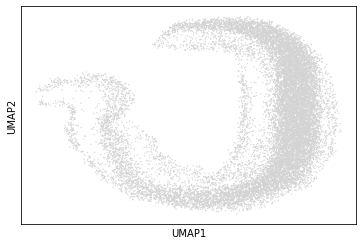

In [35]:
sc.pl.umap(adata)

### Protein embeddings

### Solution evolution

### Set up the gene features

In [38]:
import torch

all_pe = torch.load(f"/dfs/project/uce/all_species_pe_tokens.torch")
all_pe.shape

dataset_to_protein_embeddings = torch.load(f"/lfs/local/0/yanay/reduced_datasets_to_pe_chrom_5120_full.torch")

In [55]:
from tqdm import tqdm

def get_gene_embed_map(dataset):
    dataset_name = dataset
    read_adata = sc.read_h5ad(f'/lfs/local/0/yanay/cxg_h5s/{dataset_name}_proc.h5ad')
    dataset_idxs = dataset_to_protein_embeddings[dataset_name]
    return {x:y for x,y in zip(read_adata.var.index, dataset_idxs.numpy())}

In [ ]:
dataset_shapes = pd.read_csv("/dfs/project/cross-species/yanay/code/UCE/data_proc/full_train_datasets.csv", 
            index_col=0)

gene2embed = get_gene_embed_map('9f222629-9e39-47d0-b83f-e08d610c7479')
all_datasets = [x.split('.h5ad')[0] for x in dataset_shapes.dropna().sort_values('num_genes', 
                                                                ascending=False)['path'].values]

for dataset in tqdm(all_datasets, total=len(all_datasets)):
    gene2embed.update(get_gene_embed_map(dataset))

In [ ]:
#np.save('gene2embed.npy', gene2embed)

gene2embed = np.load('gene2embed.npy', allow_pickle=True).item()

In [ ]:
## Read in existing gene 2 embedding mappings
##gene2embed = get_gene_embed_map('9f222629-9e39-47d0-b83f-e08d610c7479')
##gene2embed.update(get_gene_embed_map('18e2a8c5-33f7-455e-a58a-b2ba6921db27'))

## Subset to current dataset
gene2embed = {g:gene2embed[g] for g in all_genes if g in gene2embed}

In [128]:
adata = sc.AnnData(all_pe[list(gene2embed.values())].numpy())
adata.obs.index = list(gene2embed.keys())
sc.pp.neighbors(adata)
sc.tl.umap(adata)


         Falling back to preprocessing with `sc.pp.pca` and default params.


### Load exepriment data

In [56]:
sampled_genes = []
exp_name = f'/dfs/scratch0/jianv/bio-logs/logs_40_hugebatch_IFNG/dummy_summary5/sampled_genes_{{}}.npy'
num_genes = 480

for step_id in range(30):
    try:
        exp_name_id = exp_name.format(step_id)
        sampled_genes.append(np.load(exp_name_id))
    except:
        pass

In [63]:
sampled_genes = []
exp_name = f'/dfs/user/yhr/research_assistant_orig/logs_IL2/exp3/sampled_genes_{{}}.npy'
num_genes = 480

for step_id in range(25):
    try:
        exp_name_id = exp_name.format(step_id)
        sampled_genes.append(np.load(exp_name_id))
    except:
        pass

In [64]:
true_hits = [x for x in topmovers if x in adata.obs.index]

In [103]:
"""
all_genes_considered = []
for x in glob.glob('/dfs/user/yhr/research_assistant_orig/logs_IL2/*/sampled_genes_*'):
    all_genes_considered.extend(np.load(x))
all_genes_considered = list(set(all_genes_considered))

adata.obs.index = adata.obs.index.astype('str')
all_genes_considered = [x for x in all_genes_considered if x in adata.obs.index]

adata = adata[all_genes_considered, :]
"""

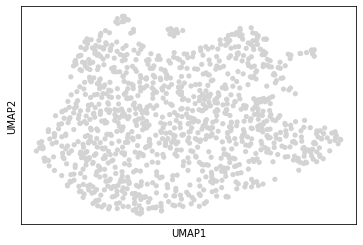

In [122]:
#sc.pp.neighbors(adata)
#sc.tl.umap(adata)
sc.pl.umap(adata)

### UMAP series

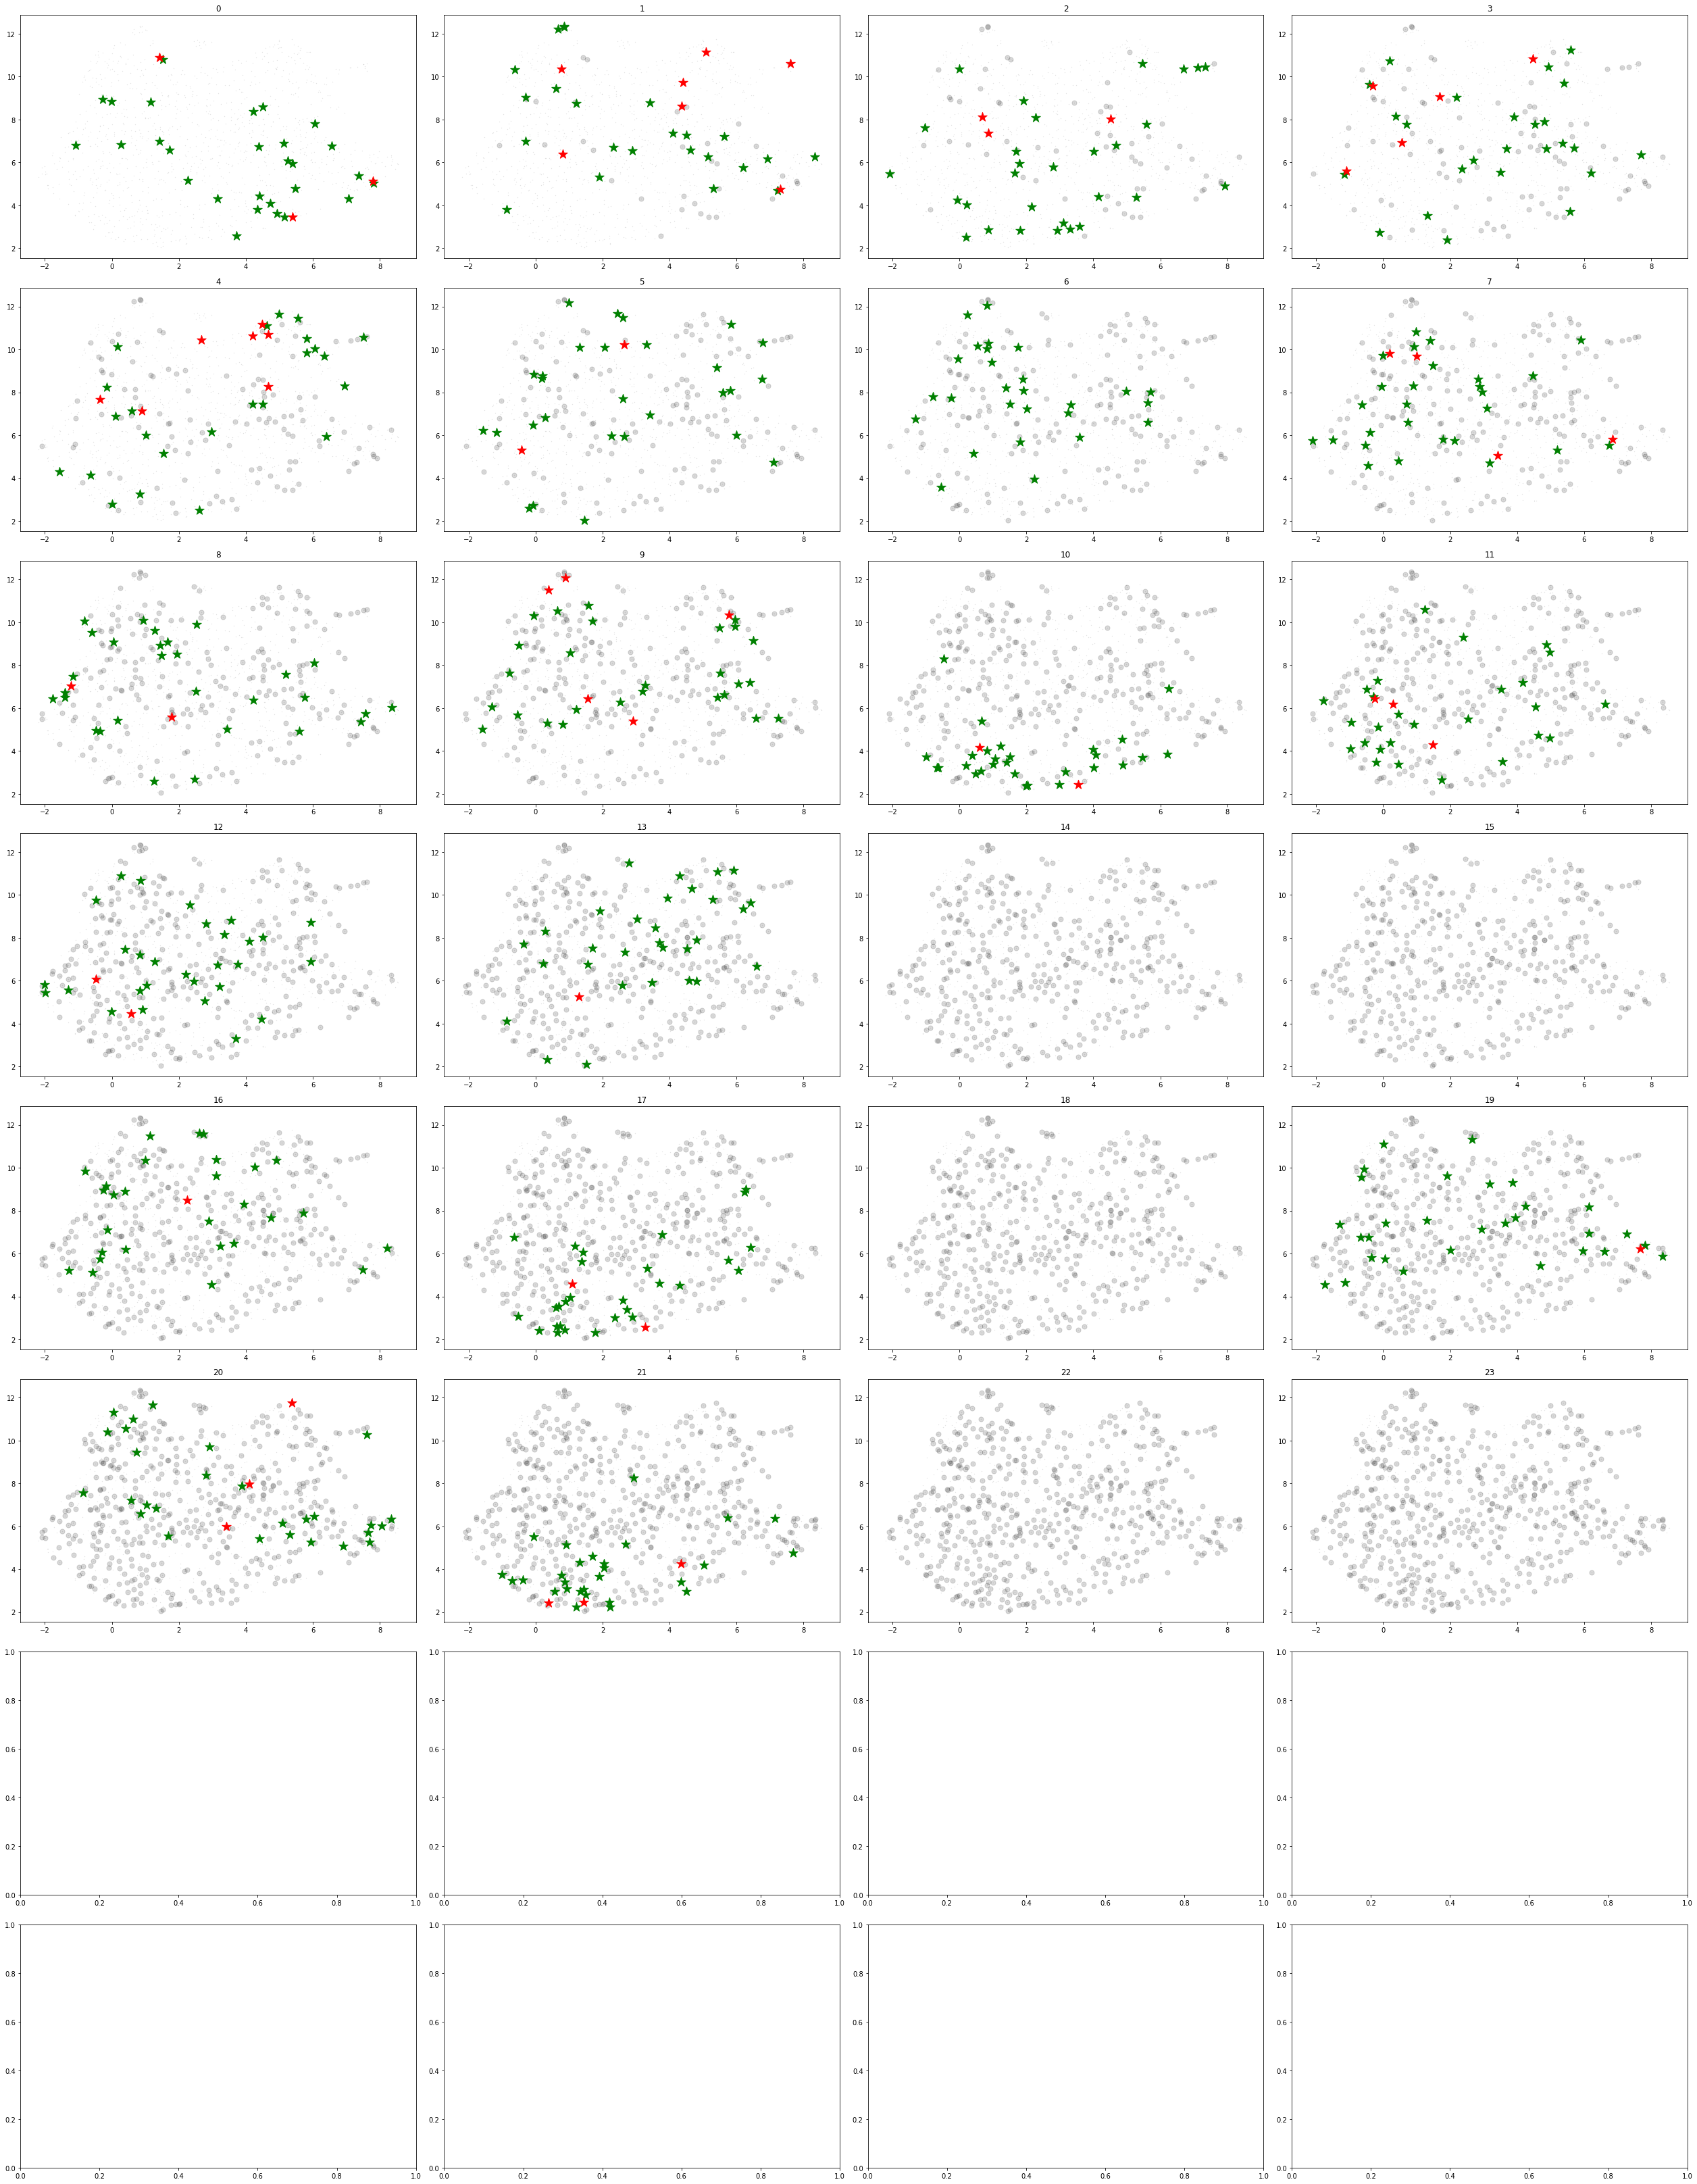

In [127]:
import matplotlib.pyplot as plt
import scanpy as sc

plot_subset = False
curr_sample=set()
samples_sofar = set()

# Determine the subplot grid size (rows x cols)
n_rows = 8
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(35,45))
space = 'X_umap'

for idx, sample in enumerate(sampled_genes):
    
    samples_sofar = list(set(samples_sofar).union(set(curr_sample)))
    hits_sofar = list(set(samples_sofar).intersection(set(true_hits)))
    curr_sample = list(set(sample).difference(set(samples_sofar)))
    
    samples_sofar = [x for x in samples_sofar if x in adata.obs.index]
    multishot_sample = [x for x in curr_sample if x in adata.obs.index]
    hits = list(set(multishot_sample).intersection(set(true_hits)))
    non_hits = list(set(multishot_sample).difference(set(true_hits)))
    
    labels = ['Past Samples'] * len(samples_sofar) +\
             ['Sampled'] * len(non_hits) +\
             ['Successful Hits'] * len(hits)
    
    subset_adata = adata[samples_sofar + non_hits + hits]
    subset_adata.obs['labels'] = labels
    label_map = subset_adata.obs['labels'].to_dict()
    
    row = idx // n_cols
    col = idx % n_cols
    
    plt.subplot(n_rows, n_cols, idx + 1)  # +1 since idx starts from 0, subplots are 1-indexed
    
    adata.obs['hit_labels'] = adata.obs.index.map(label_map)
    adata.obs['hit_labels'] = adata.obs['hit_labels'].fillna('None')
    adata.uns['hit_labels_colors'] = ['gray','black', 'green', 'red']
    axs[row, col].scatter(adata.obsm[space][:,0], adata.obsm[space][:,1], s=0.1, c='gray', alpha=0.3)
    
    subset = adata[adata.obs['hit_labels'] == 'Past Samples']
    axs[row, col].scatter(subset.obsm[space][:,0], subset.obsm[space][:,1], s=50, c='black', alpha=0.15)
    
    subset = adata[adata.obs['hit_labels'] == 'Sampled']
    axs[row, col].scatter(subset.obsm[space][:,0], subset.obsm[space][:,1], s=200, c='green', marker='*')
    
    subset = adata[adata.obs['hit_labels'] == 'Successful Hits']
    axs[row, col].scatter(subset.obsm[space][:,0], subset.obsm[space][:,1], s=200, c='red', marker='*')
    #sc.pl.umap(adata, groups=['Past Samples', 'Sampled', 'Successful Hits'], 
    #           color='hit_labels', ax=axs[row, col], show=False, legend_loc=None)
    axs[row, col].set_ylabel('')
    axs[row, col].set_xlabel('')
    axs[row, col].set_title(idx)

plt.tight_layout()
plt.show()


/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/ipykernel_launcher.py:29: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


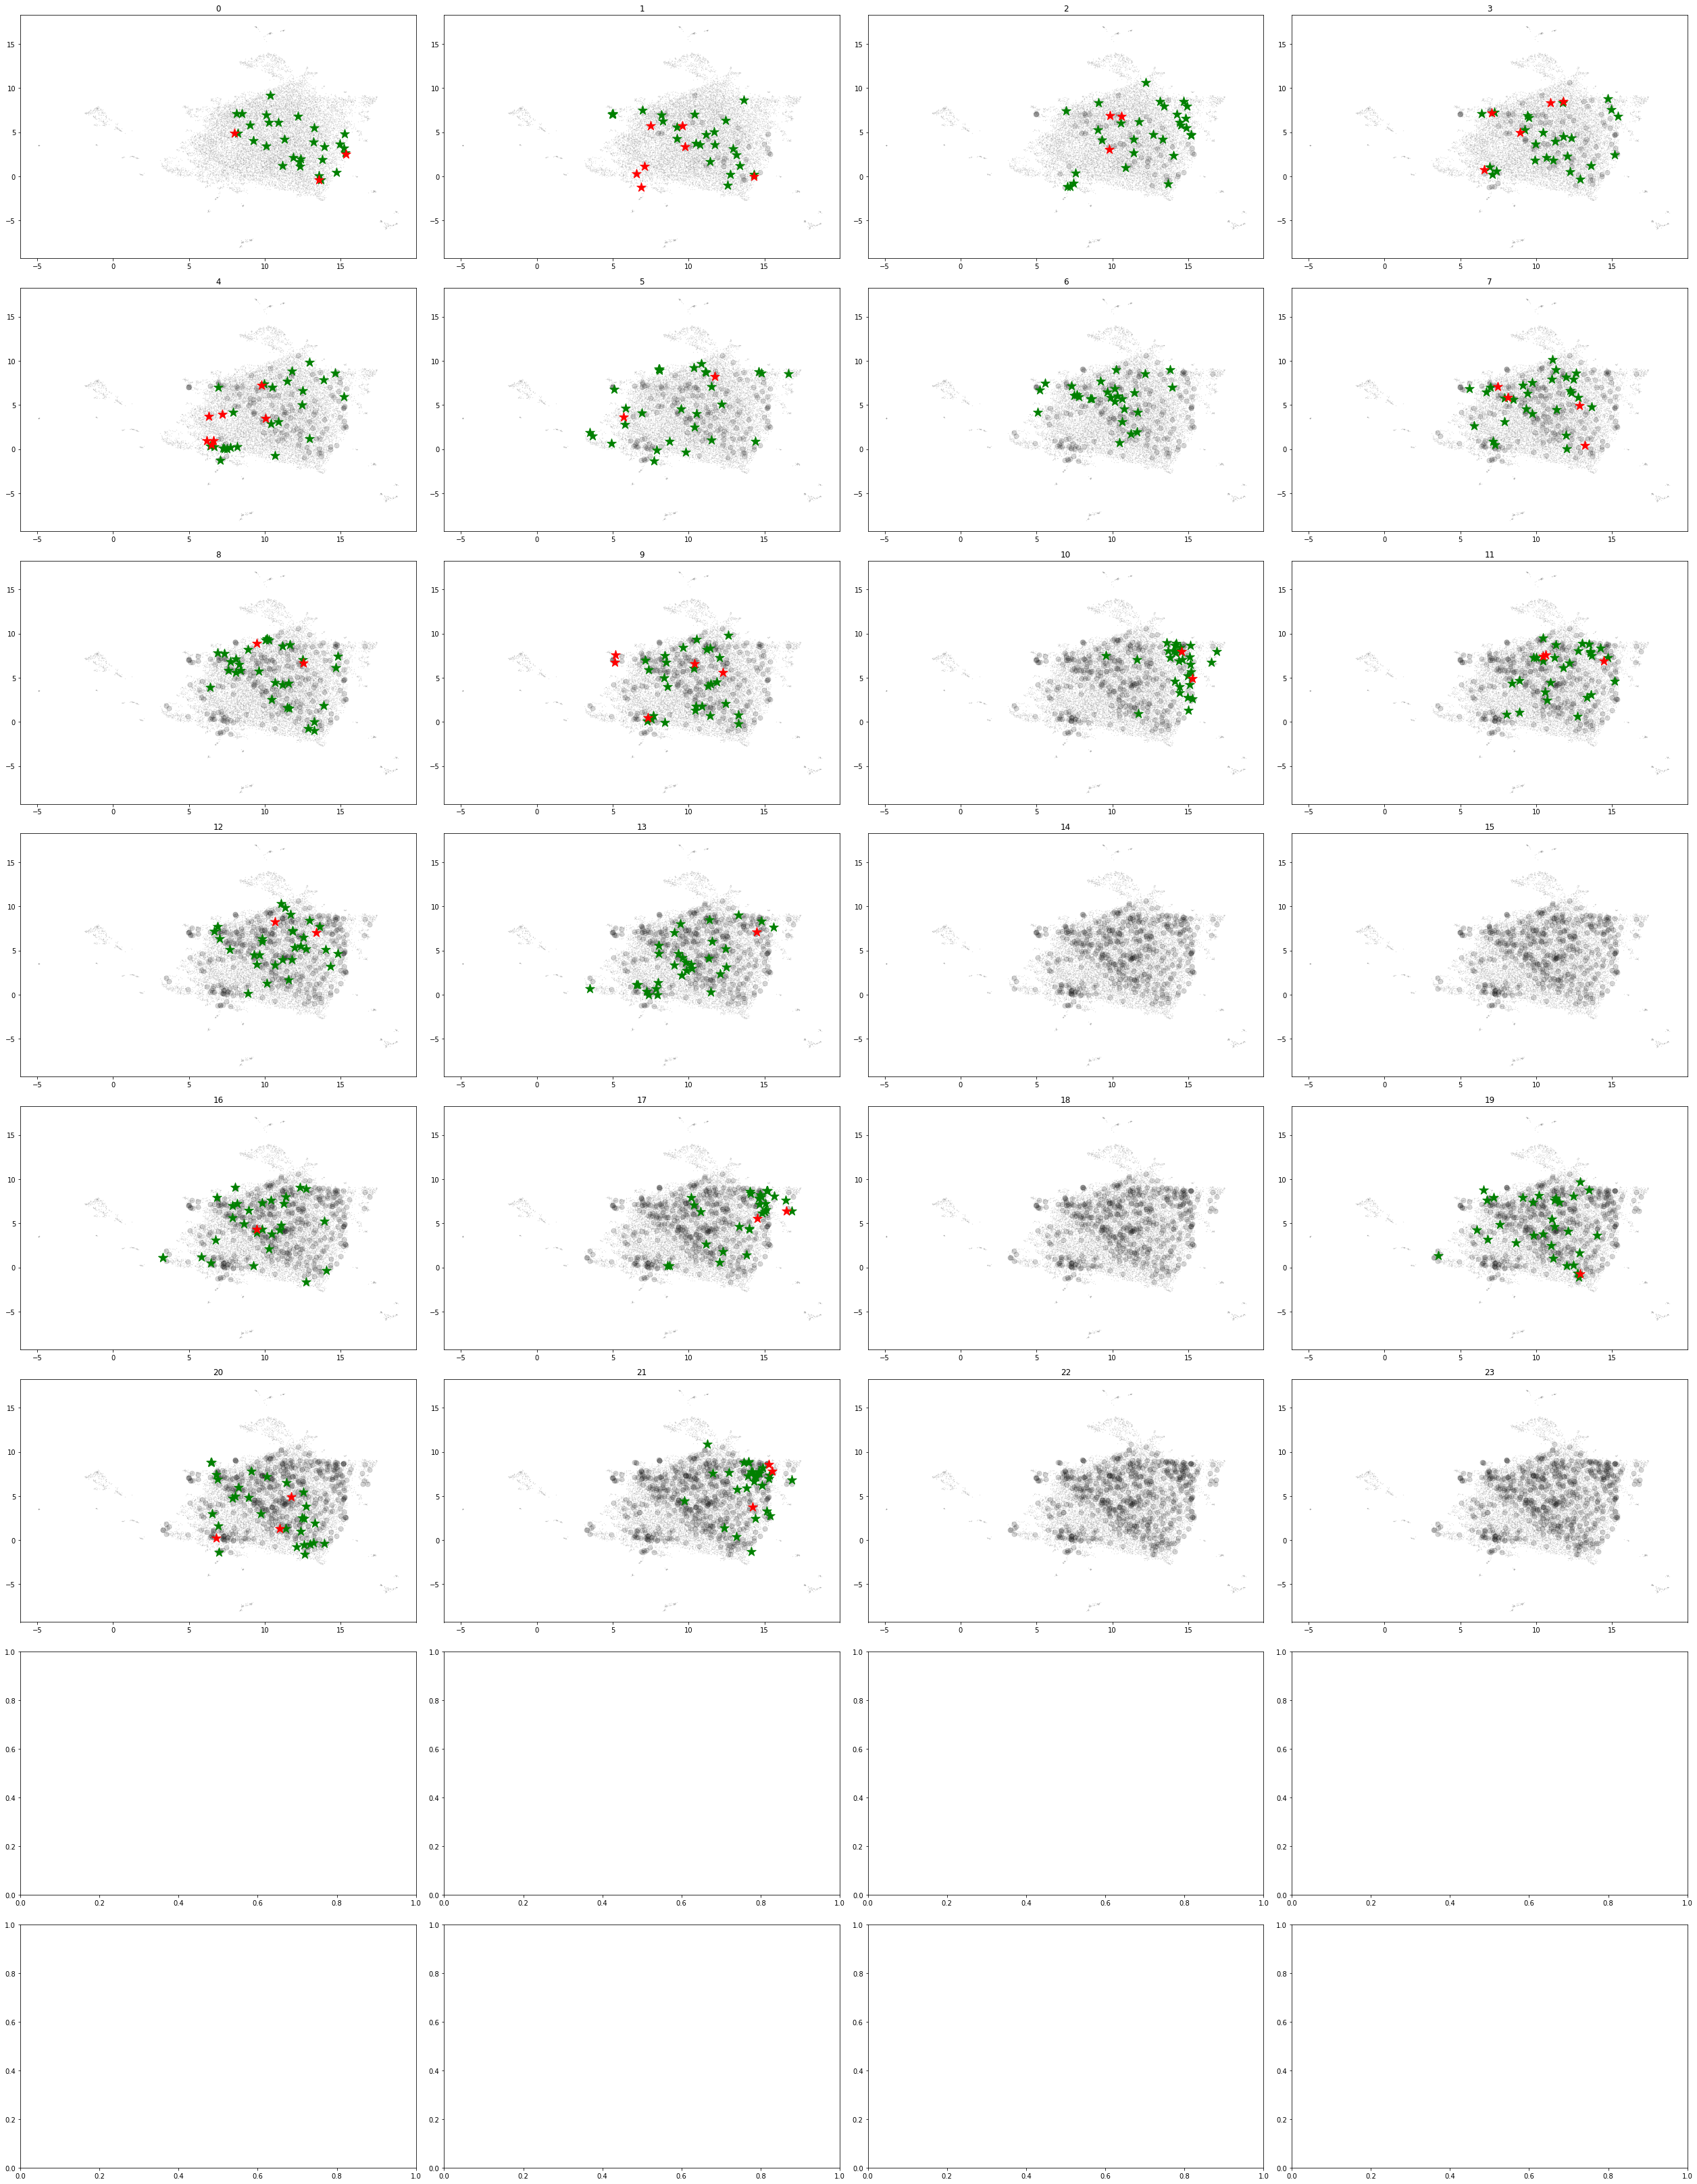

In [65]:
import matplotlib.pyplot as plt
import scanpy as sc

plot_subset = False
curr_sample=set()
samples_sofar = set()

# Determine the subplot grid size (rows x cols)
n_rows = 8
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(35,45))

for idx, sample in enumerate(sampled_genes):
    
    samples_sofar = list(set(samples_sofar).union(set(curr_sample)))
    hits_sofar = list(set(samples_sofar).intersection(set(true_hits)))
    curr_sample = list(set(sample).difference(set(samples_sofar)))
    
    samples_sofar = [x for x in samples_sofar if x in adata.obs.index]
    multishot_sample = [x for x in curr_sample if x in adata.obs.index]
    hits = list(set(multishot_sample).intersection(set(true_hits)))
    non_hits = list(set(multishot_sample).difference(set(true_hits)))
    
    labels = ['Past Samples'] * len(samples_sofar) +\
             ['Sampled'] * len(non_hits) +\
             ['Successful Hits'] * len(hits)
    
    subset_adata = adata[samples_sofar + non_hits + hits]
    subset_adata.obs['labels'] = labels
    label_map = subset_adata.obs['labels'].to_dict()
    
    row = idx // n_cols
    col = idx % n_cols
    
    plt.subplot(n_rows, n_cols, idx + 1)  # +1 since idx starts from 0, subplots are 1-indexed
    
    adata.obs['hit_labels'] = adata.obs.index.map(label_map)
    adata.obs['hit_labels'] = adata.obs['hit_labels'].fillna('None')
    adata.uns['hit_labels_colors'] = ['gray','black', 'green', 'red']
    axs[row, col].scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], s=0.1, c='gray', alpha=0.3)
    
    subset = adata[adata.obs['hit_labels'] == 'Past Samples']
    axs[row, col].scatter(subset.obsm['X_umap'][:,0], subset.obsm['X_umap'][:,1], s=50, c='black', alpha=0.15)
    
    subset = adata[adata.obs['hit_labels'] == 'Sampled']
    axs[row, col].scatter(subset.obsm['X_umap'][:,0], subset.obsm['X_umap'][:,1], s=200, c='green', marker='*')
    
    subset = adata[adata.obs['hit_labels'] == 'Successful Hits']
    axs[row, col].scatter(subset.obsm['X_umap'][:,0], subset.obsm['X_umap'][:,1], s=200, c='red', marker='*')
    #sc.pl.umap(adata, groups=['Past Samples', 'Sampled', 'Successful Hits'], 
    #           color='hit_labels', ax=axs[row, col], show=False, legend_loc=None)
    axs[row, col].set_ylabel('')
    axs[row, col].set_xlabel('')
    axs[row, col].set_title(idx)

plt.tight_layout()
plt.show()


### bar plot series

In [149]:
import warnings
warnings.filterwarnings('ignore')

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [154]:
sc.tl.leiden(adata, resolution=0.2)

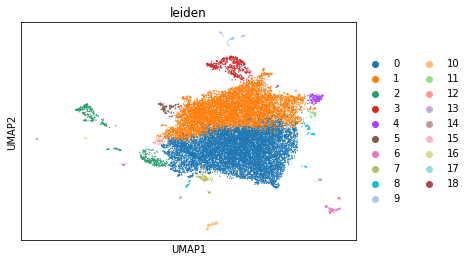

In [155]:
sc.pl.umap(adata, color='leiden')

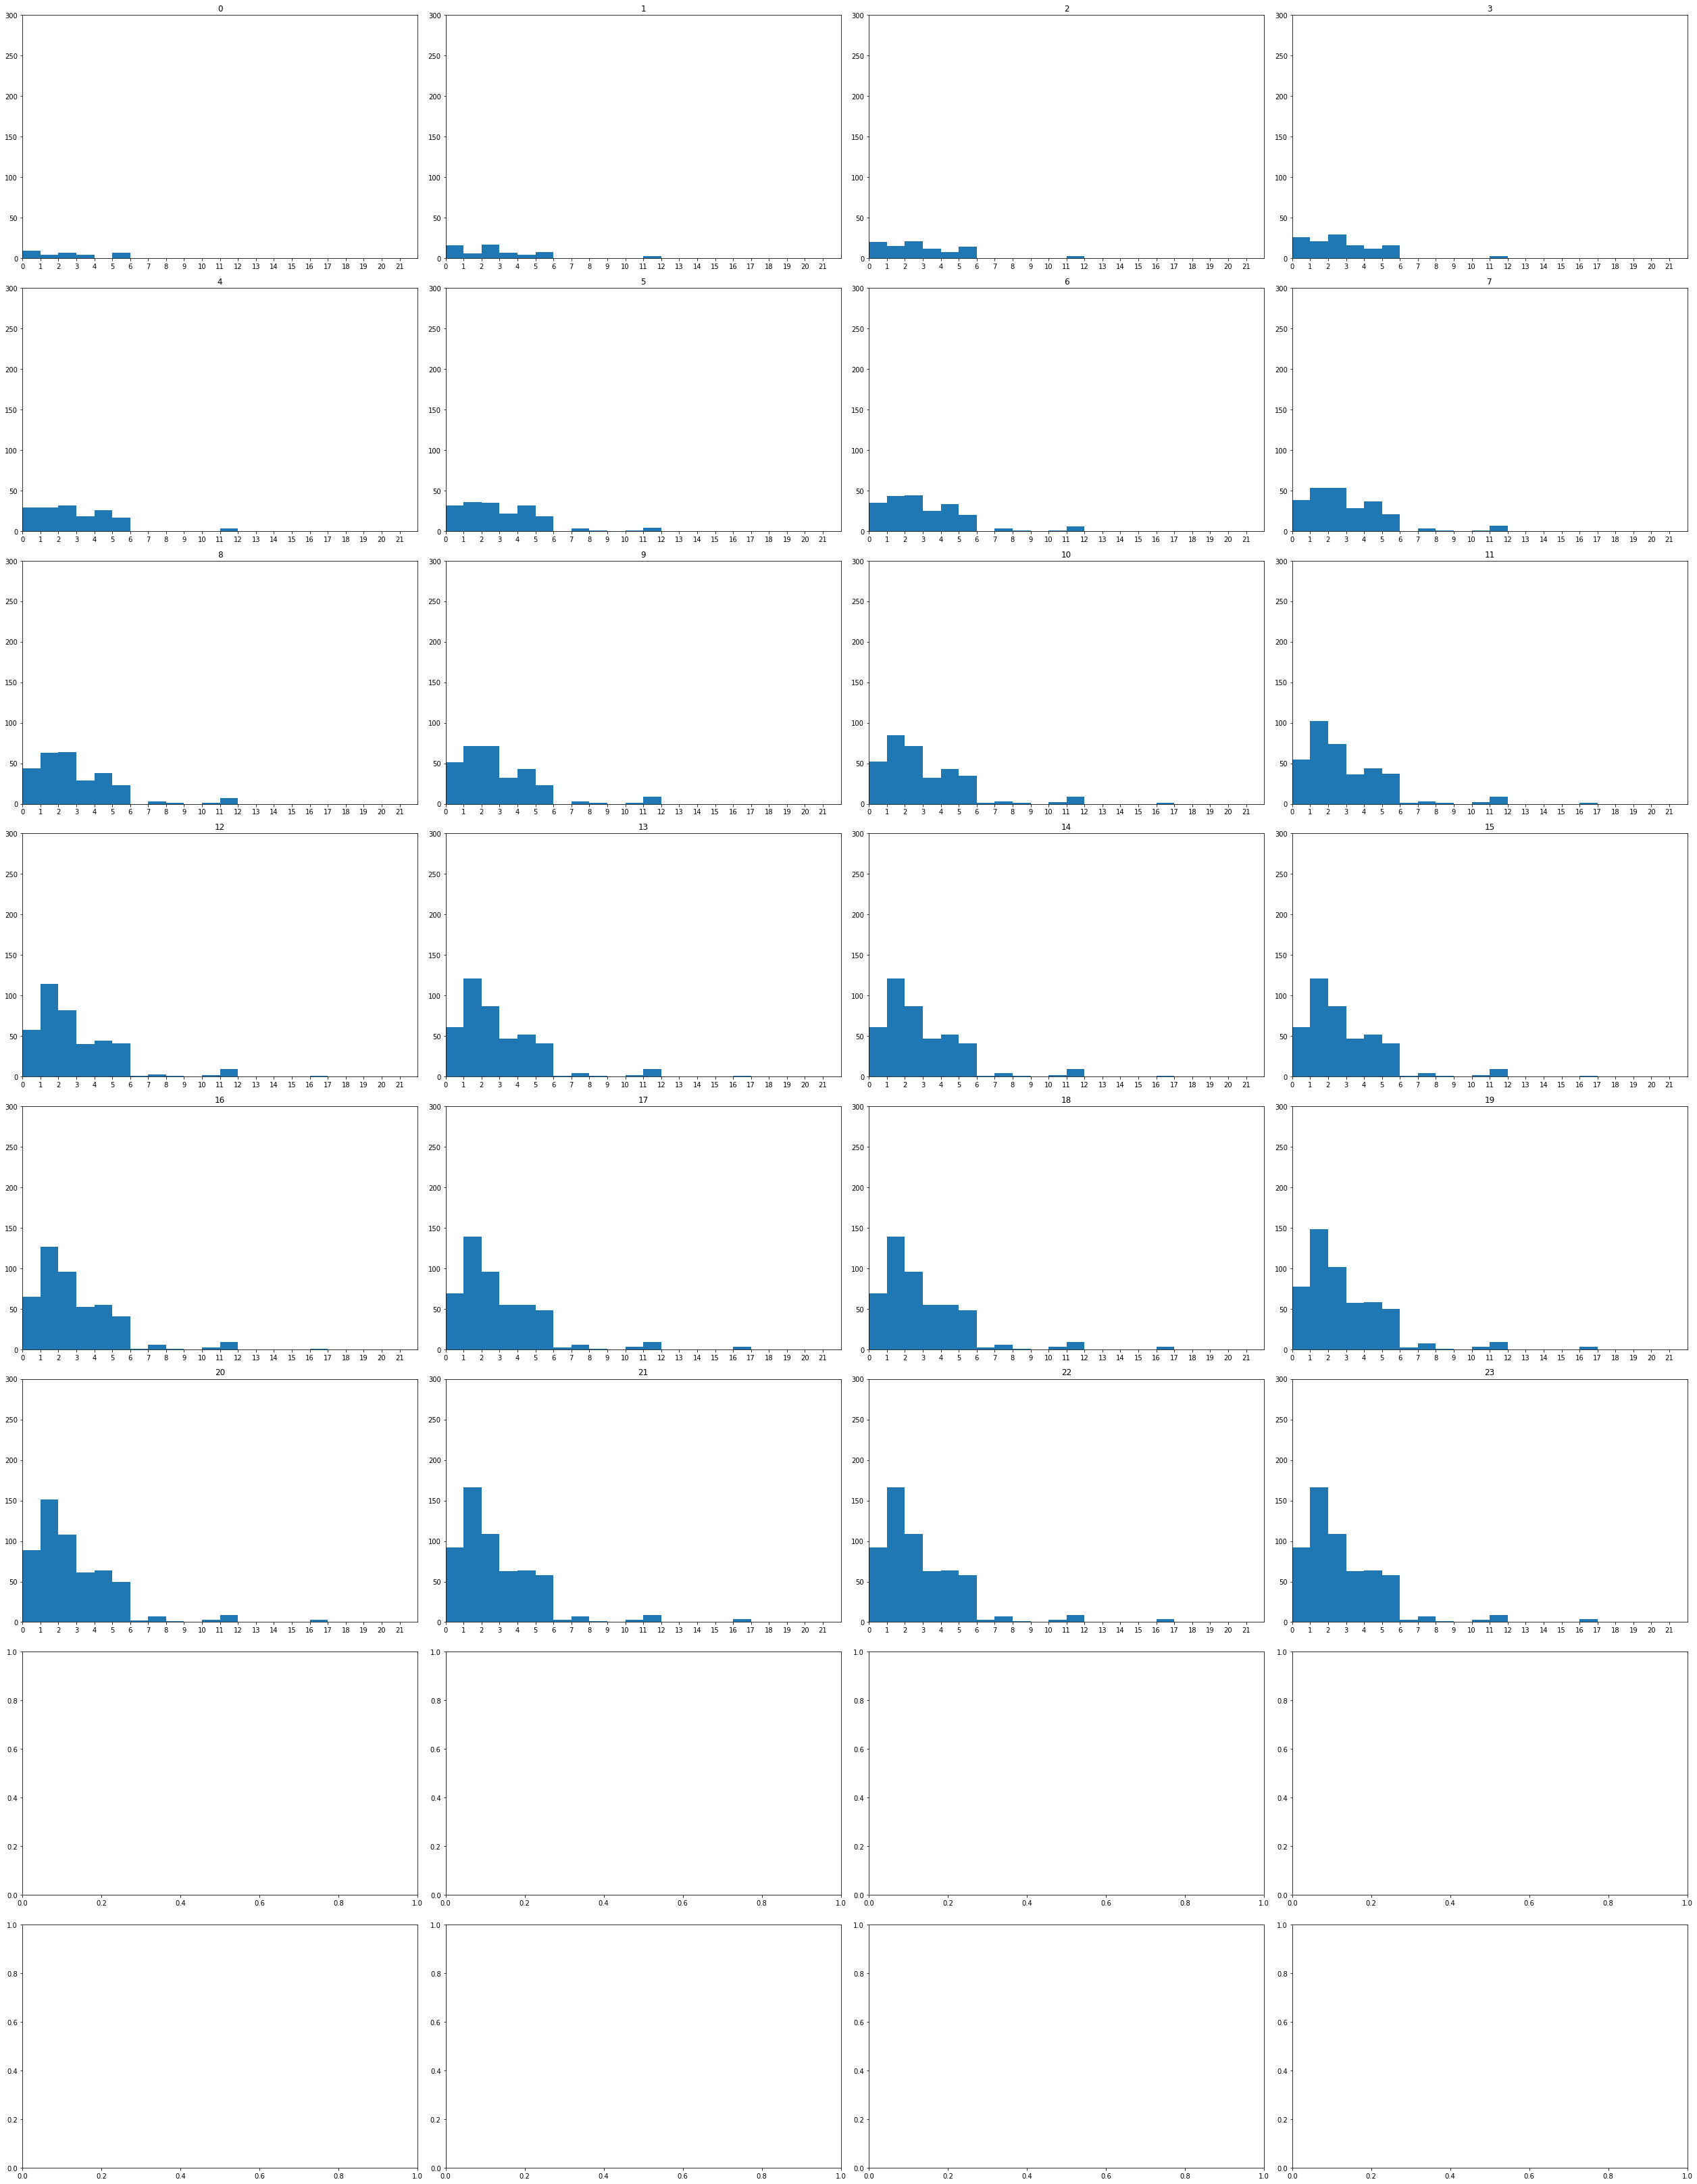

In [81]:
import matplotlib.pyplot as plt
import scanpy as sc

plot_subset = False
curr_sample=set()
samples_sofar = set()

# Determine the subplot grid size (rows x cols)
n_rows = 8
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(35,45))

adata.obs['leiden'] = adata.obs['leiden'].astype('int')

for idx, sample in enumerate(sampled_genes):
    
    samples_sofar = list(set(samples_sofar).union(set(curr_sample)))
    hits_sofar = list(set(samples_sofar).intersection(set(true_hits)))
    curr_sample = list(set(sample).difference(set(samples_sofar)))
    
    samples_sofar = [x for x in samples_sofar if x in adata.obs.index]
    multishot_sample = [x for x in curr_sample if x in adata.obs.index]
    hits = list(set(multishot_sample).intersection(set(true_hits)))
    non_hits = list(set(multishot_sample).difference(set(true_hits)))
    
    labels = ['Past Samples'] * len(samples_sofar) +\
             ['Sampled'] * len(non_hits) +\
             ['Successful Hits'] * len(hits)
    
    subset_adata = adata[samples_sofar + non_hits + hits]
    subset_adata.obs['labels'] = labels
    label_map = subset_adata.obs['labels'].to_dict()
    
    row = idx // n_cols
    col = idx % n_cols
    
    plt.subplot(n_rows, n_cols, idx + 1)  # +1 since idx starts from 0, subplots are 1-indexed
    
    adata.obs['hit_labels'] = adata.obs.index.map(label_map)
    adata.obs['hit_labels'] = adata.obs['hit_labels'].fillna('None')
    adata.uns['hit_labels_colors'] = ['gray','black', 'green', 'red']
    
    xticks = np.sort([int(x) for x in adata.obs['leiden'].unique()])
    xticklabels = xticks.astype('str')
    
    axs[row, col].set_xticks(xticks)  
    axs[row, col].set_xticklabels(xticklabels)
    axs[row, col].set_xlim([0, len(xticks)])
    plt.hist(adata[~adata.obs['hit_labels'].isin(['None'])].obs['leiden'].values,
             bins=range(len(xticks)))
    #sc.pl.embedding(adata, basis='X_dens', groups=['Past Samples', 'Sampled', 'Successful Hits'], 
    #           color='hit_labels', ax=axs[row, col], show=False, legend_loc=None)
    axs[row, col].set_ylabel('')
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylim([0, 300])
    
    axs[row, col].set_title(idx)

plt.tight_layout()
plt.show()


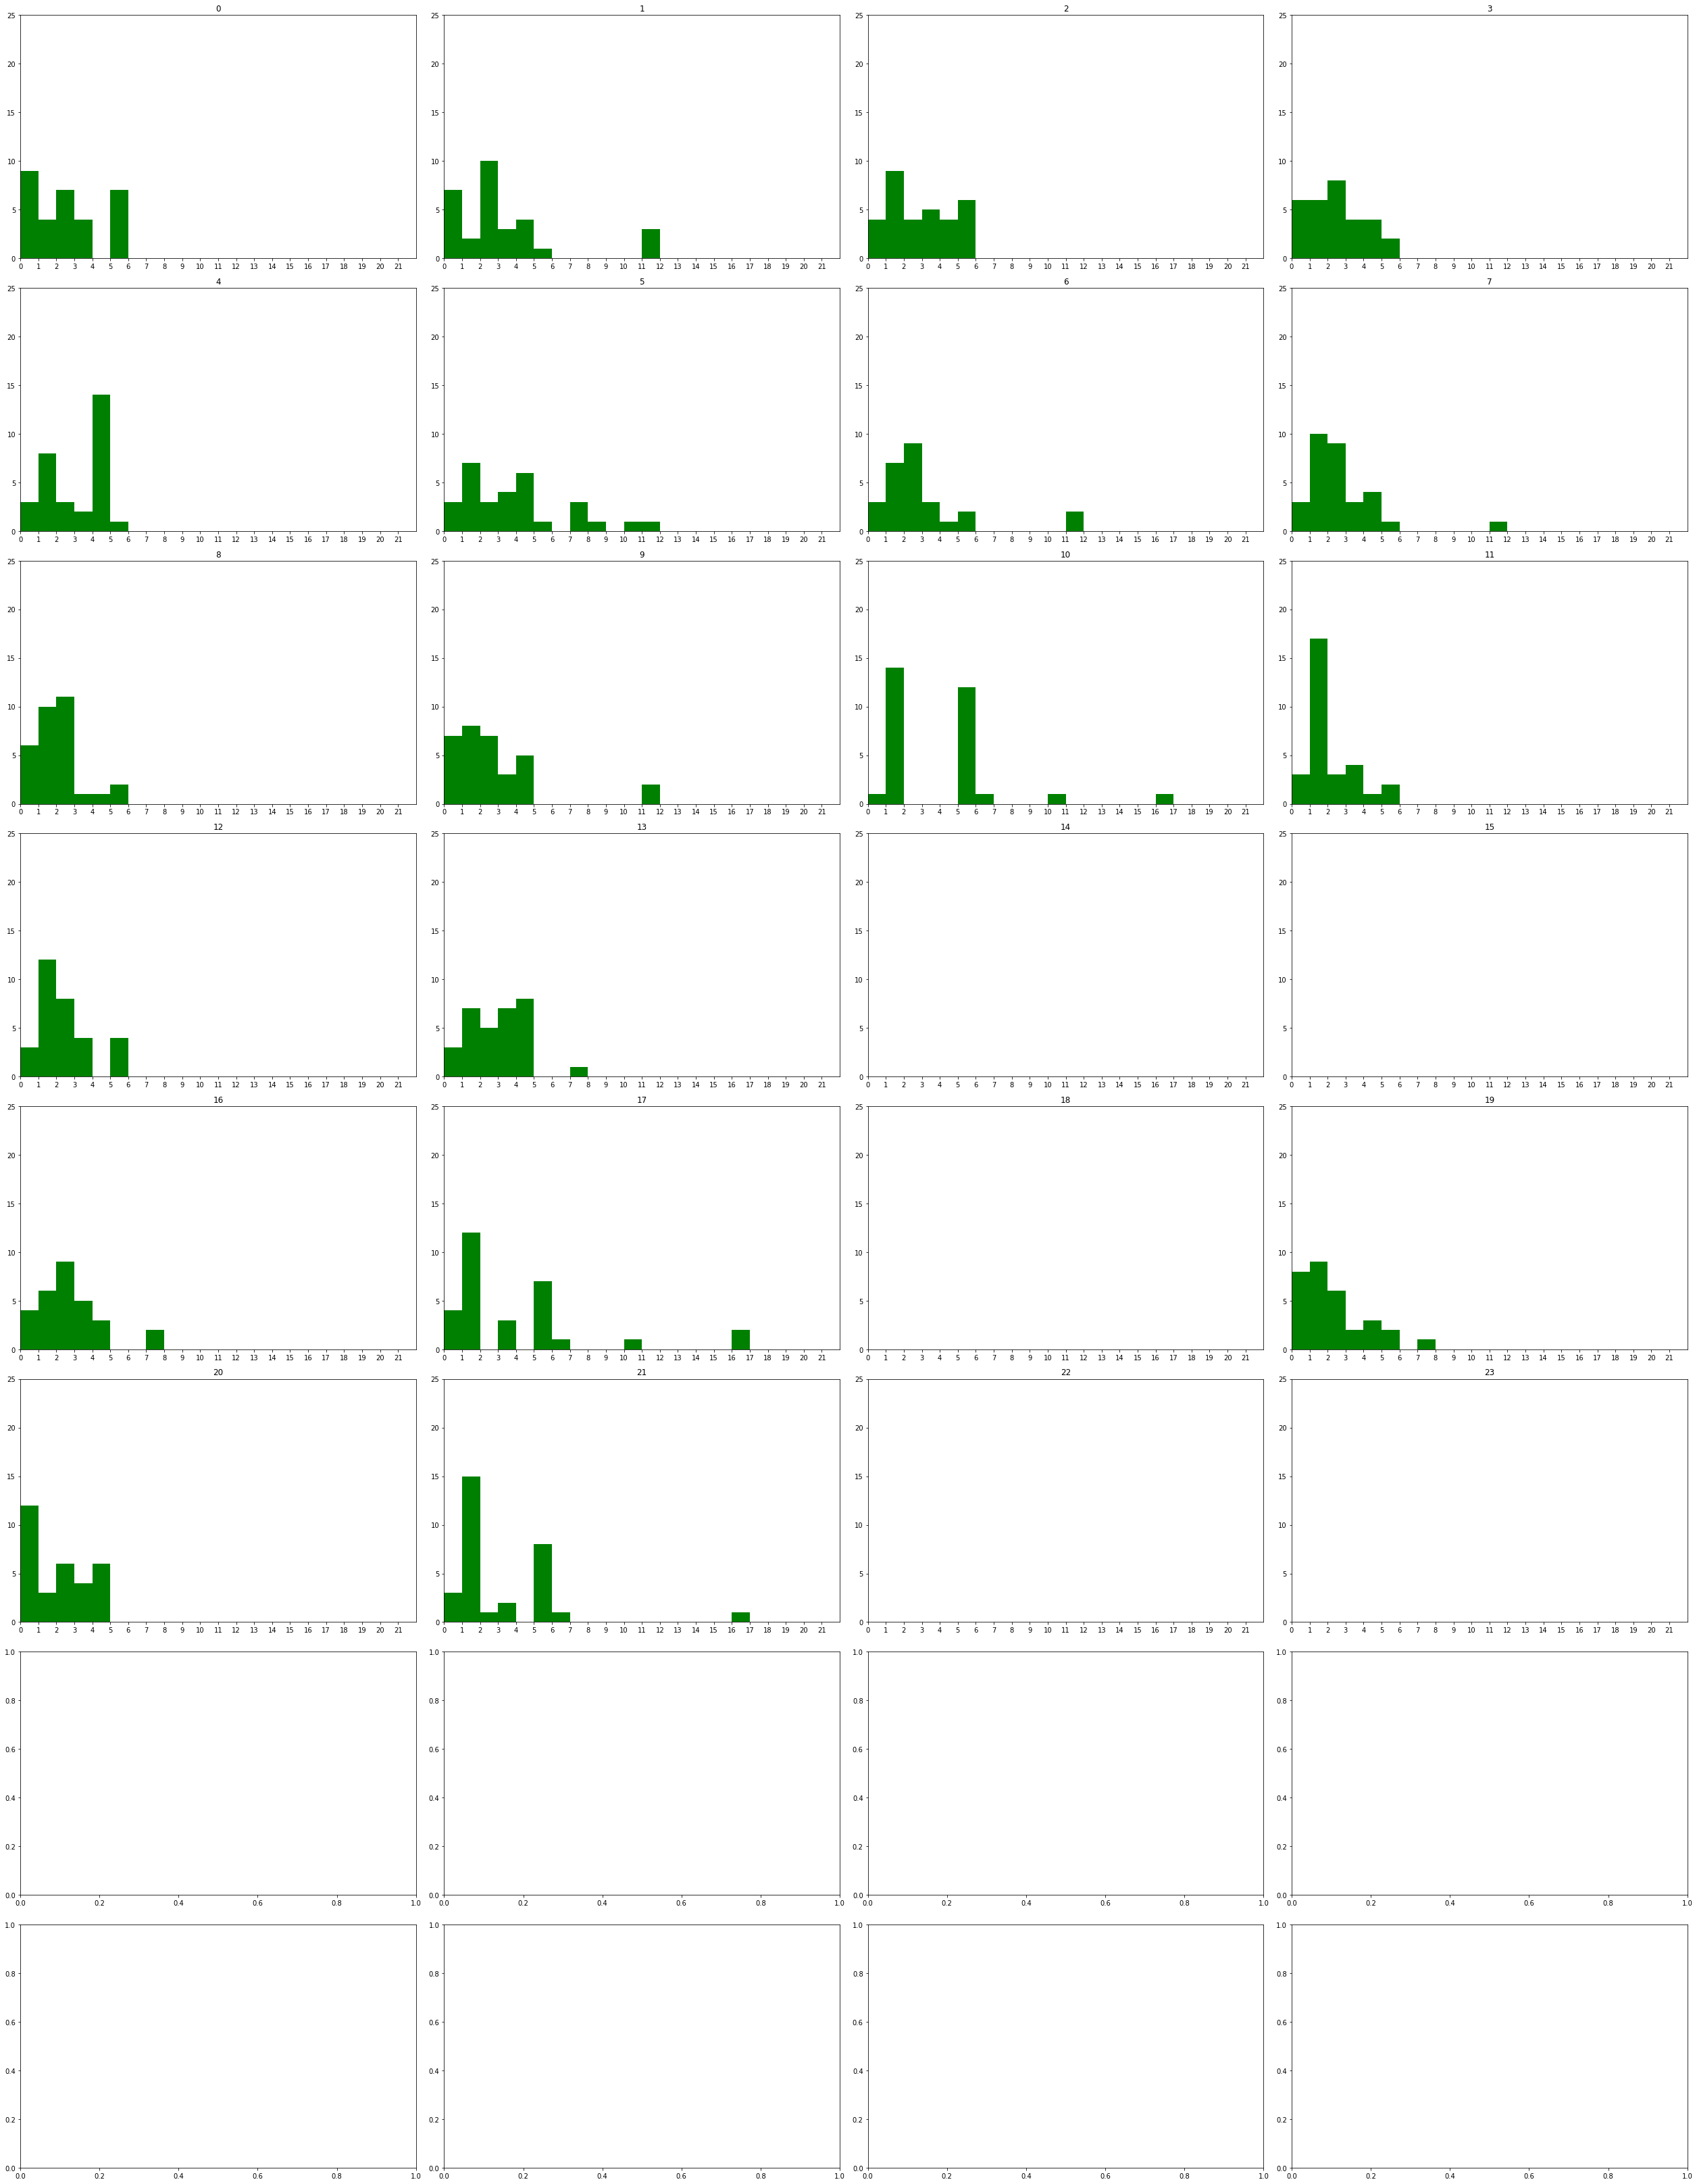

In [82]:
import matplotlib.pyplot as plt
import scanpy as sc

plot_subset = False
curr_sample=set()
samples_sofar = set()

# Determine the subplot grid size (rows x cols)
# Determine the subplot grid size (rows x cols)
n_rows = 8
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(35,45))

adata.obs['leiden'] = adata.obs['leiden'].astype('int')

for idx, sample in enumerate(sampled_genes):
    
    samples_sofar = list(set(samples_sofar).union(set(curr_sample)))
    hits_sofar = list(set(samples_sofar).intersection(set(true_hits)))
    curr_sample = list(set(sample).difference(set(samples_sofar)))
    
    samples_sofar = [x for x in samples_sofar if x in adata.obs.index]
    multishot_sample = [x for x in curr_sample if x in adata.obs.index]
    hits = list(set(multishot_sample).intersection(set(true_hits)))
    non_hits = list(set(multishot_sample).difference(set(true_hits)))
    
    labels = ['Past Samples'] * len(samples_sofar) +\
             ['Sampled'] * len(non_hits) +\
             ['Successful Hits'] * len(hits)
    
    subset_adata = adata[samples_sofar + non_hits + hits]
    subset_adata.obs['labels'] = labels
    label_map = subset_adata.obs['labels'].to_dict()
    
    row = idx // n_cols
    col = idx % n_cols
    
    plt.subplot(n_rows, n_cols, idx + 1)  # +1 since idx starts from 0, subplots are 1-indexed
    
    adata.obs['hit_labels'] = adata.obs.index.map(label_map)
    adata.obs['hit_labels'] = adata.obs['hit_labels'].fillna('None')
    adata.uns['hit_labels_colors'] = ['gray','black', 'green', 'red']
    
    xticks = np.sort([int(x) for x in adata.obs['leiden'].unique()])
    xticklabels = xticks.astype('str')
    
    axs[row, col].set_xticks(xticks)  
    axs[row, col].set_xticklabels(xticklabels)
    axs[row, col].set_xlim([0, len(xticks)])
    plt.hist(adata[adata.obs['hit_labels'].isin(['Sampled', 'Successful Hits'])].obs['leiden'].values,
             bins=range(len(xticks)), rwidth = 1, color='green')
    #sc.pl.embedding(adata, basis='X_dens', groups=['Past Samples', 'Sampled', 'Successful Hits'], 
    #           color='hit_labels', ax=axs[row, col], show=False, legend_loc=None)
    axs[row, col].set_ylabel('')
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylim([0, 25])
    
    axs[row, col].set_title(idx)

plt.tight_layout()
plt.show()


In [83]:
adata.obs['leiden'] = adata.obs['leiden'].astype('str')

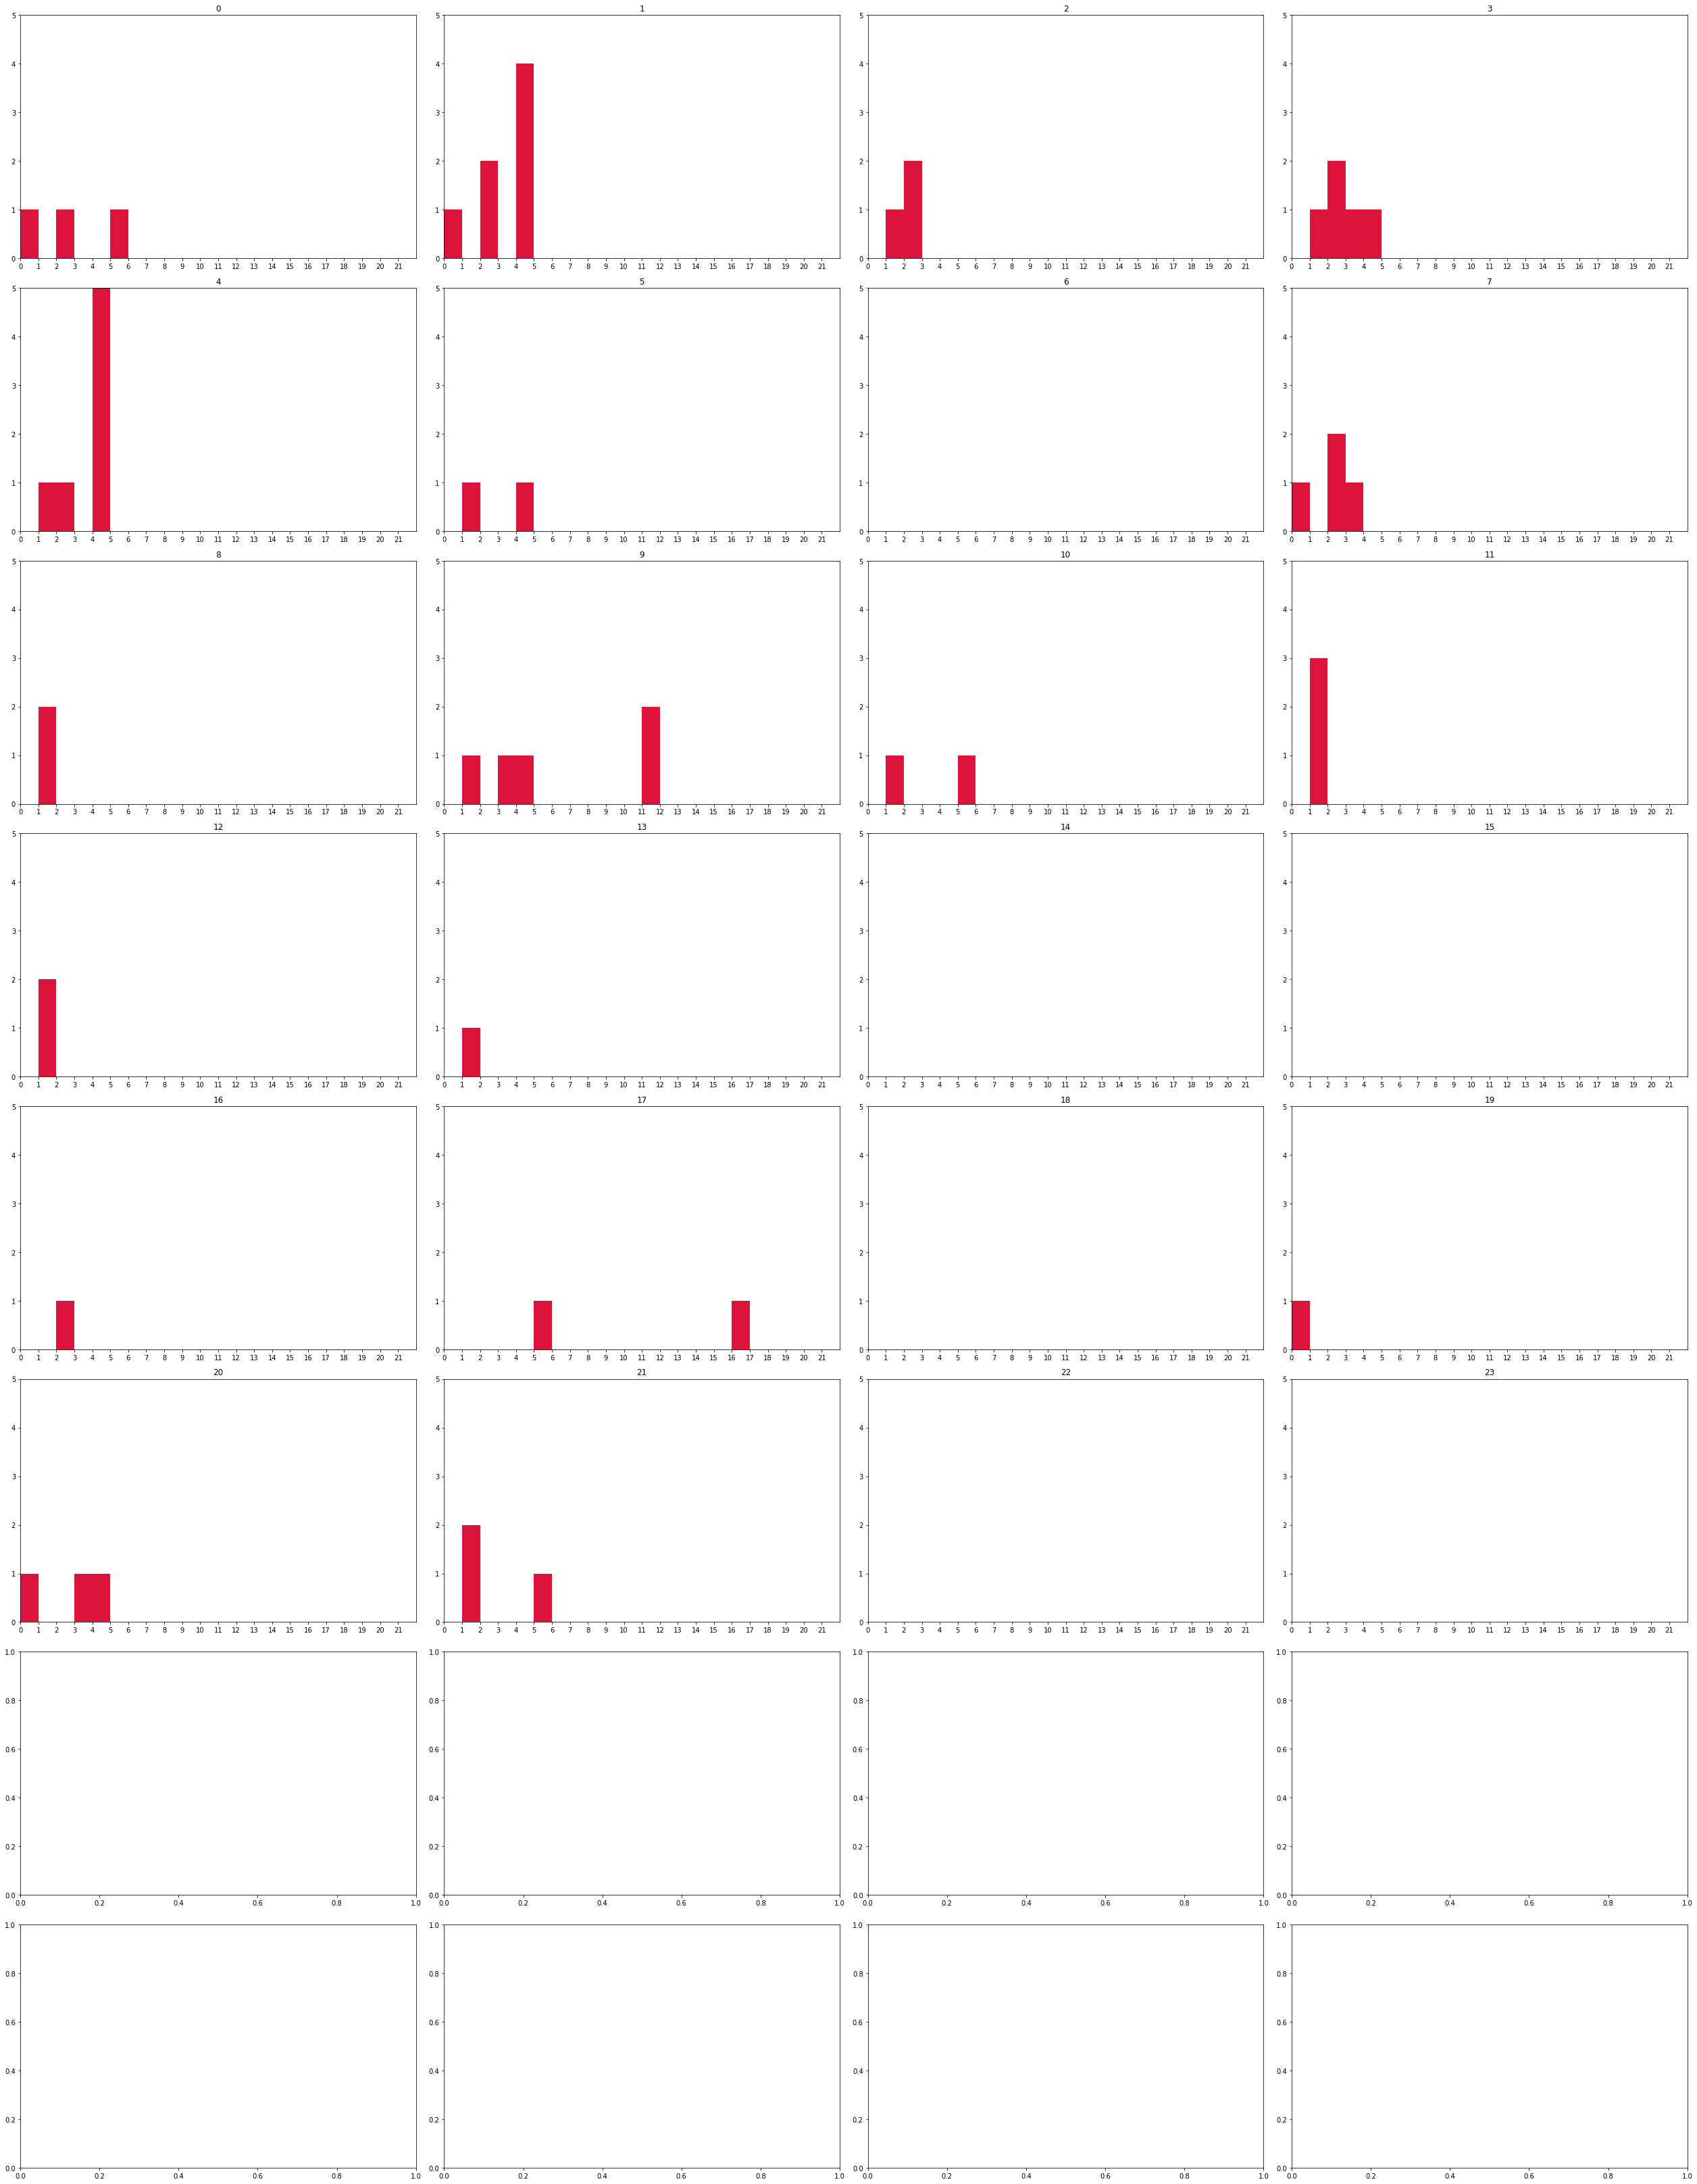

In [84]:
import matplotlib.pyplot as plt
import scanpy as sc

plot_subset = False
curr_sample=set()
samples_sofar = set()

# Determine the subplot grid size (rows x cols)
# Determine the subplot grid size (rows x cols)
n_rows = 8
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(35,45))

adata.obs['leiden'] = adata.obs['leiden'].astype('int')

for idx, sample in enumerate(sampled_genes):
    
    samples_sofar = list(set(samples_sofar).union(set(curr_sample)))
    hits_sofar = list(set(samples_sofar).intersection(set(true_hits)))
    curr_sample = list(set(sample).difference(set(samples_sofar)))
    
    samples_sofar = [x for x in samples_sofar if x in adata.obs.index]
    multishot_sample = [x for x in curr_sample if x in adata.obs.index]
    hits = list(set(multishot_sample).intersection(set(true_hits)))
    non_hits = list(set(multishot_sample).difference(set(true_hits)))
    
    labels = ['Past Samples'] * len(samples_sofar) +\
             ['Sampled'] * len(non_hits) +\
             ['Successful Hits'] * len(hits)
    
    subset_adata = adata[samples_sofar + non_hits + hits]
    subset_adata.obs['labels'] = labels
    label_map = subset_adata.obs['labels'].to_dict()
    
    all_hits_sampled = {x:'Hit' for x in hits_sofar + hits}
    adata.obs['hits_sampled'] = adata.obs.index.map(all_hits_sampled)
    
    row = idx // n_cols
    col = idx % n_cols
    
    plt.subplot(n_rows, n_cols, idx + 1)  # +1 since idx starts from 0, subplots are 1-indexed
    
    adata.obs['hit_labels'] = adata.obs.index.map(label_map)
    adata.obs['hit_labels'] = adata.obs['hit_labels'].fillna('None')
    adata.uns['hit_labels_colors'] = ['gray','black', 'green', 'red']
    
    xticks = np.sort([int(x) for x in adata.obs['leiden'].unique()])
    xticklabels = xticks.astype('str')
    
    plt.hist(adata[adata.obs['hit_labels'].isin(['Successful Hits'])].obs['leiden'].values, color='crimson',
            bins=range(len(xticks)))
    axs[row, col].set_xticks(xticks)  
    axs[row, col].set_xticklabels(xticklabels)
    axs[row, col].set_xlim([0, len(xticks)])
    axs[row, col].set_ylabel('')
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylim([0, 5])
    
    axs[row, col].set_title(idx)

plt.tight_layout()
plt.show()


In [335]:
adata.obs['leiden'] = adata.obs['leiden'].astype('str')

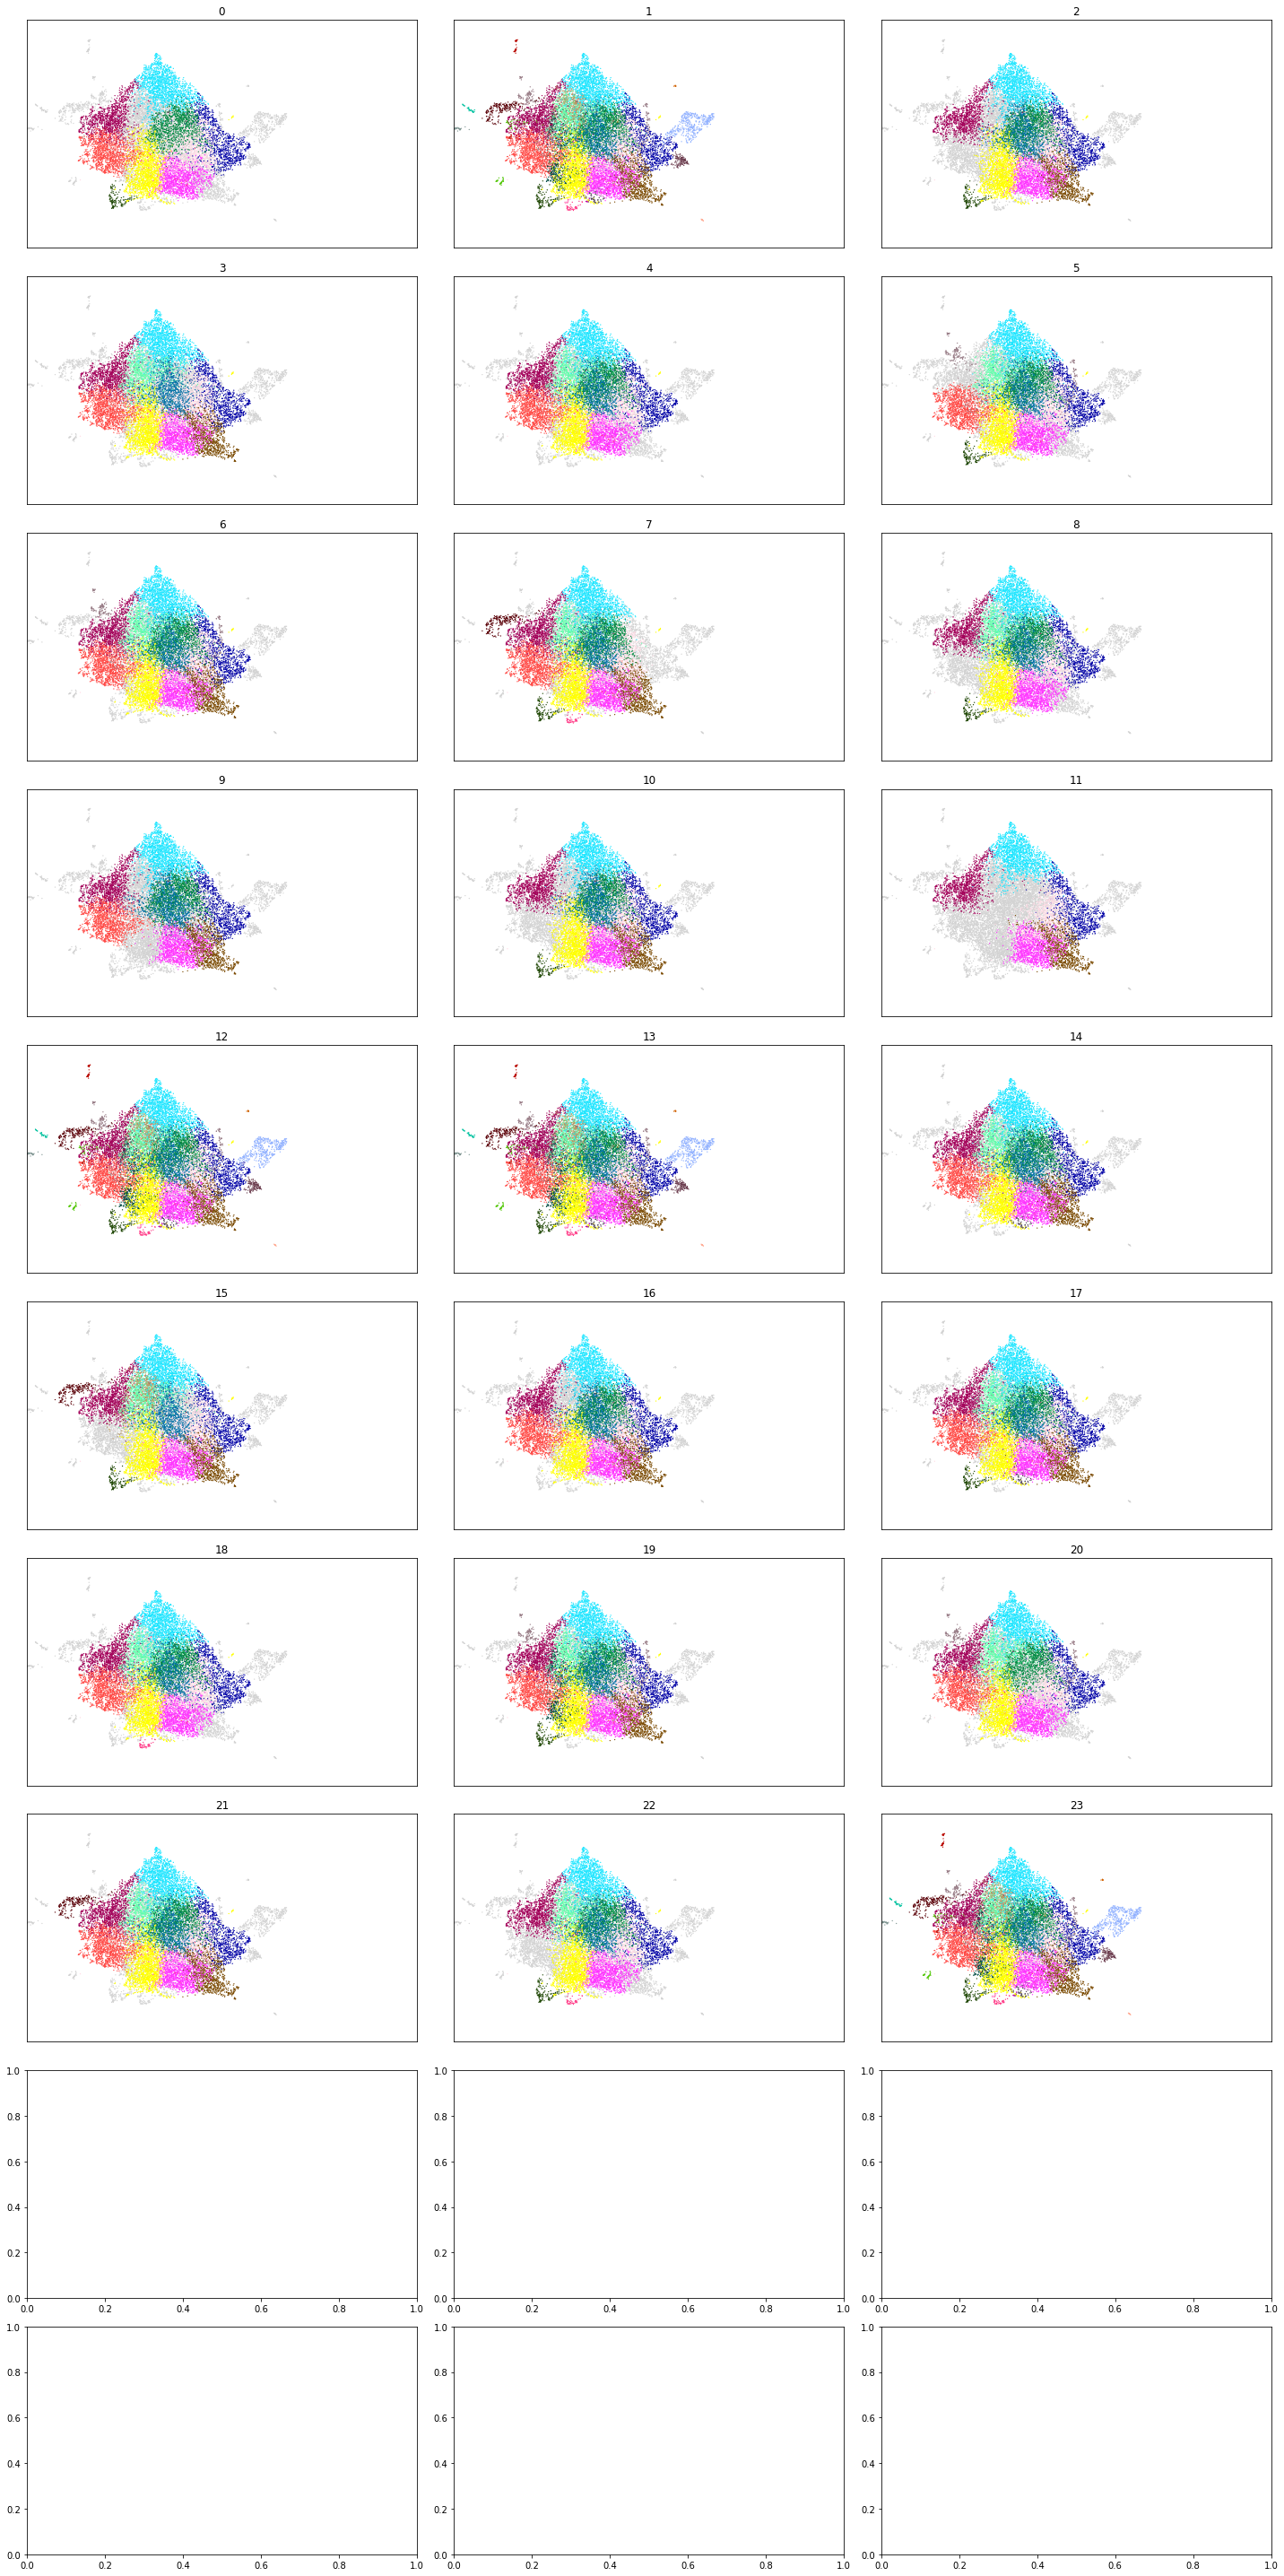

In [336]:
import matplotlib.pyplot as plt
import scanpy as sc

plot_subset = False
curr_sample=set()
samples_sofar = set()

# Determine the subplot grid size (rows x cols)
n_rows = 10
n_cols = 3
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,40))


for idx, sample in enumerate(sampled_genes):
    
    samples_sofar = list(set(samples_sofar).union(set(curr_sample)))
    hits_sofar = list(set(samples_sofar).intersection(set(true_hits)))
    curr_sample = list(set(sample).difference(set(samples_sofar)))
    
    samples_sofar = [x for x in samples_sofar if x in adata.obs.index]
    multishot_sample = [x for x in curr_sample if x in adata.obs.index]
    hits = list(set(multishot_sample).intersection(set(true_hits)))
    non_hits = list(set(multishot_sample).difference(set(true_hits)))
    
    labels = ['Past Samples'] * len(samples_sofar) +\
             ['Sampled'] * len(non_hits) +\
             ['Successful Hits'] * len(hits)
    
    subset_adata = adata[samples_sofar + non_hits + hits]
    subset_adata.obs['labels'] = labels
    label_map = subset_adata.obs['labels'].to_dict()
    
    row = idx // n_cols
    col = idx % n_cols
    
    plt.subplot(n_rows, n_cols, idx + 1)  # +1 since idx starts from 0, subplots are 1-indexed
    
    adata.obs['hit_labels'] = adata.obs.index.map(label_map)
    adata.obs['hit_labels'] = adata.obs['hit_labels'].fillna('None')
    adata.uns['hit_labels_colors'] = ['gray','black', 'green', 'red']
    
    xticks = np.sort([int(x) for x in adata.obs['leiden'].unique()])
    xticklabels = xticks.astype('str')
    
    axs[row, col].set_xticks(xticks)  
    axs[row, col].set_xticklabels(xticklabels)
    axs[row, col].set_xlim([0, len(xticks)])
    groups_to_keep = adata[adata.obs['hit_labels'].isin(['Sampled', 'Successful Hits'])].obs['leiden'].values
    groups_to_keep = [str(x) for x in np.unique(groups_to_keep)]
    sc.pl.umap(adata, groups=groups_to_keep, 
               color='leiden', ax=axs[row, col], show=False, legend_loc=None)
    axs[row, col].set_ylabel('')
    axs[row, col].set_xlabel('')
    axs[row, col].set_ylim([0, 20])
    
    axs[row, col].set_title(idx)

plt.tight_layout()
plt.show()


In [ ]:
import umap
dens_mapper = umap.UMAP(densmap=True, random_state=42).fit(adata.X)
embed = dens_mapper.fit_transform(adata.X)
adata.obsm['X_dens'] = embed

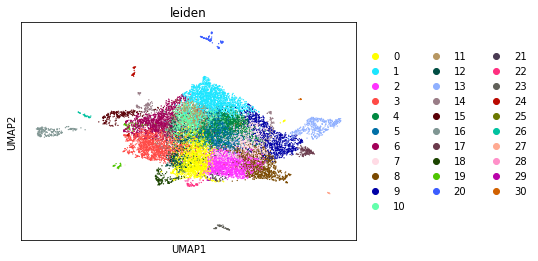

In [280]:
sc.tl.leiden(adata, resolution=1.0)
sc.pl.umap(adata, color='leiden')

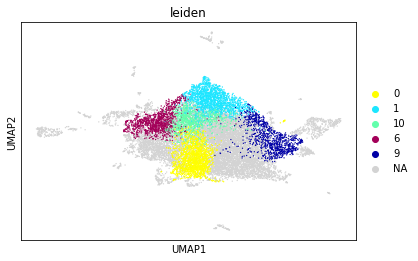

In [450]:
sc.pl.umap(adata, color='leiden', groups=['6', '9', '10','0', '1'])

In [449]:
adata.obs['leiden'] = adata.obs['leiden'].astype('str')